# 1. Setup

In [1]:
!pip install -q umap-learn

In [9]:
import numpy as np 
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import lightgbm as lgb, xgboost as xgb, catboost as cb
from gc import collect
import os
import matplotlib.pyplot as plt
import umap
from matplotlib.ticker import MaxNLocator
import scipy
import seaborn as sns
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_curve, make_scorer
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest
from sklearn.linear_model import LogisticRegression, RidgeClassifier,RidgeClassifierCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [10]:
%%time
def get_feats(mode='TRAIN'):
    feats=pd.read_excel(f"data\\{mode}\\{mode}_QUANTITATIVE_METADATA.xlsx")
    
    cate=pd.read_excel(f"data\\{mode}\\{mode}_CATEGORICAL_METADATA.xlsx")
        
    feats=feats.merge(cate,on='participant_id',how='left')
    
    func=pd.read_csv(f"data\\{mode}\\{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    
    feats=feats.merge(func,on='participant_id',how='left')

    if mode=='TRAIN':
        solution=pd.read_excel("data\TRAIN\TRAINING_SOLUTIONS.xlsx")
        feats=feats.merge(solution,on='participant_id',how='left')
        
    return feats
    
train=get_feats(mode='TRAIN')
test=get_feats(mode='TEST')
sub = pd.read_excel('data\SAMPLE_SUBMISSION.xlsx')
y = pd.read_excel("data\TRAIN\TRAINING_SOLUTIONS.xlsx")

CPU times: total: 8.8 s
Wall time: 8.89 s


In [15]:
train

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,...,-0.280312,0.037560,0.423037,0.242453,0.336213,0.402338,0.327915,0.539032,1,0
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,...,-0.332783,-0.332711,0.556939,0.475578,0.429196,0.457970,0.312571,0.595978,1,0
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,...,-0.002132,-0.175586,0.679183,0.290292,0.486680,0.255208,0.575017,0.605182,0,1
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,...,-0.199576,-0.216457,0.519074,0.298586,0.415466,0.511607,0.361204,0.446613,0,1
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,...,-0.141012,-0.002865,0.515169,0.336139,0.316430,0.442230,0.177079,0.378278,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,zwjJWCRzKhDz,100.00,14.0,3.0,14.0,36.0,18.0,13.0,22.0,5.0,...,0.112789,0.211312,0.601190,0.587116,0.312695,0.485938,0.189102,0.354333,0,1
1209,zwXD5v17Rx01,46.67,14.0,3.0,18.0,42.0,21.0,15.0,25.0,2.0,...,0.253990,0.198741,0.648260,0.055241,0.491985,0.118676,0.404331,0.537121,1,0
1210,zWzLCi3NTBTd,-40.00,14.0,3.0,19.0,34.0,20.0,20.0,25.0,2.0,...,0.044653,0.234887,0.538475,0.024265,0.472322,0.095624,0.205326,0.182633,1,1
1211,Zy9GTHDxUbXU,100.00,14.0,3.0,9.0,45.0,23.0,11.0,30.0,1.0,...,-0.035955,-0.062152,0.706214,0.183288,0.104987,0.420463,0.152727,0.706737,1,0


In [12]:
test

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,86.71,14.0,3.0,17.0,41.0,17.0,11.0,25.0,1.0,...,0.021524,-0.162832,0.105546,0.028975,0.576180,0.378365,0.399277,0.556115,0.490833,0.568742
300,IUEHiLmQAqCi,73.37,14.0,5.0,12.0,38.0,22.0,9.0,29.0,2.0,...,0.044974,-0.078047,-0.118271,0.035741,0.640073,0.515096,0.206462,0.536001,0.318518,0.305596
301,cRySmCadYFRO,87.84,13.0,3.0,14.0,42.0,15.0,10.0,28.0,1.0,...,0.145582,0.004455,0.134574,-0.152951,0.782938,0.737555,0.593972,0.734463,0.680979,0.678973
302,E3MvDUtJadc5,46.76,14.0,3.0,16.0,43.0,18.0,12.0,22.0,5.0,...,0.036169,-0.345563,-0.165280,-0.347035,0.657024,0.590523,0.094565,0.727339,0.429694,0.530238


In [16]:
train.set_index('participant_id', inplace=True)
test.set_index('participant_id', inplace=True)
targets = ['ADHD_Outcome', 'Sex_F']
features = test.columns

In [21]:
features

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total',
       ...
       '195throw_196thcolumn', '195throw_197thcolumn', '195throw_198thcolumn',
       '195throw_199thcolumn', '196throw_197thcolumn', '196throw_198thcolumn',
       '196throw_199thcolumn', '197throw_198thcolumn', '197throw_199thcolumn',
       '198throw_199thcolumn'],
      dtype='object', length=19927)

# 2. Data Preprocessing

In [23]:
def check_nan(df):
    if df.isnull().any().any():
        print('There are NaN values')
    else:
        print('There are no NaN values')

        
check_nan(train)
check_nan(test)
print(f'Train: {train.shape}, Test: {test.shape}')

There are NaN values
There are NaN values
Train: (1213, 19929), Test: (304, 19927)


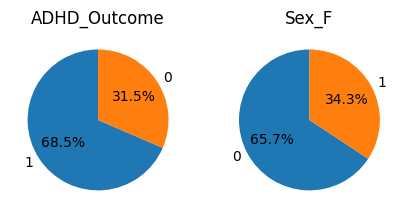

In [24]:
fig, axs = plt.subplots(1,2, figsize=(5,3))

for col, ax in zip(y.drop('participant_id',axis=1), axs):    
    counts = y[col].value_counts()
    ax.pie(counts, labels=counts.index, 
           autopct='%1.1f%%', 
           startangle=90)
    ax.set_title(f'{col}')

# 3. Modeling
We are using a Ridge model

In [25]:
log_features = [f for f in features if (train[f] >= 0).all() and scipy.stats.skew(train[f]) > 0]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(targets, axis=1),
    y[targets],
    test_size=0.3,
    random_state=42,
)

model = MultiOutputClassifier(make_pipeline(       
    ColumnTransformer([('imputer',SimpleImputer(),features)], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas'),
    ColumnTransformer([('log',FunctionTransformer(np.log1p), log_features)], remainder='passthrough'),
    MinMaxScaler(),     
    RidgeClassifier(alpha=100)))

In [28]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.600265604249668


# 4. Evaluation

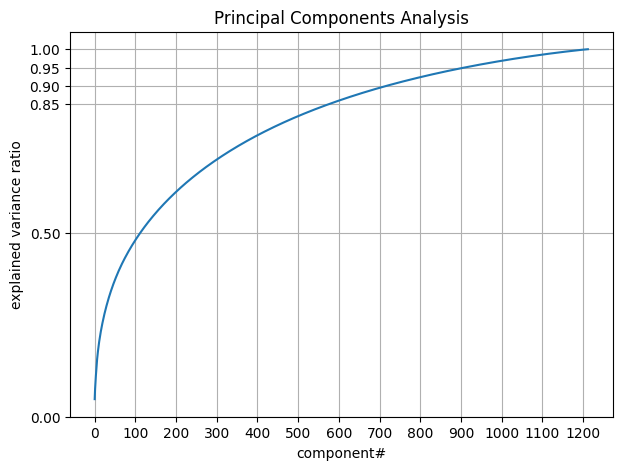

In [29]:
pca = make_pipeline(SimpleImputer(),StandardScaler(),PCA())
pca.fit(train[test.columns])
plt.figure(figsize=(7,5))
plt.plot(pca[-1].explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks([0,0.5,0.85,0.90,0.95,1])
plt.xticks(range(0,1300,100))
plt.grid()
plt.show()

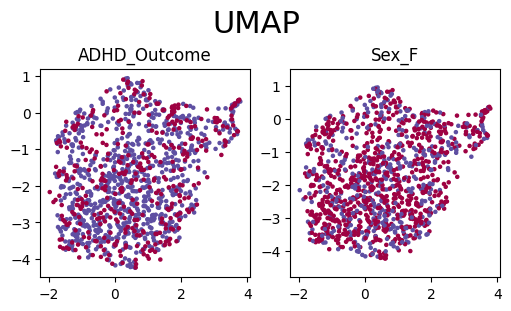

In [30]:
pipe = make_pipeline(SimpleImputer(),MinMaxScaler())
reducer = umap.UMAP()
x_scaler = pipe.fit_transform(train[features])
reducer.fit(x_scaler)
_, axs = plt.subplots(1,2, figsize=(5,3), constrained_layout=True)
embedding = reducer.transform(x_scaler)
for t,ax in zip(targets,axs.ravel()):    
    ax.scatter(embedding[:, 0], embedding[:, 1], c=y[t], cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    ax.set_title(f'{t}')
plt.suptitle('UMAP',fontsize=22);

# 6. Submission

In [31]:
model = MultiOutputClassifier(make_pipeline(ColumnTransformer([('imputer',SimpleImputer(),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                                            MinMaxScaler(),  
                                            PCA(1087),
                                            RidgeClassifier(alpha=100)))
model.fit(train.drop(targets,axis=1),
          y.drop('participant_id',axis=1))
y_pred = model.predict(test)
sub['ADHD_Outcome'] = y_pred[:,0]
sub['Sex_F'] = y_pred[:,1]
sub.to_csv('submission.csv',index=False)